In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

# Define Func

In [145]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_text(text, min_length):

    # drop non-english words
    words = set(nltk.corpus.words.words())
    # " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())

    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    text_lower = text.lower()
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words) & (x in words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return text_norm

In [146]:
def visualize_training_results(results):
    history = results.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    # fig.suptitle('Horizontally stacked subplots')

    ax1.plot(history['accuracy'])
    ax1.plot(history['loss'])
    ax1.legend(['accuracy', 'loss'])
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(history['val_accuracy'])
    ax2.plot(history['accuracy'])
    ax2.legend(['val_accuracy', 'accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy');

In [147]:
def heatmap_predicted_results(X_test, y_test, model):
    y_predicted = model.predict(X_test) > 0.5
    mat = confusion_matrix(y_test, y_predicted)

    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, ax=ax)

# Import Data

In [148]:
df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
df.head()

,Title,Userscore,Comment
0,The Legend of Zelda: Ocarina of Time,10.0,"Everything in OoT is so near at perfection, it..."
1,The Legend of Zelda: Ocarina of Time,10.0,I won't bore you with what everyone is already...
2,The Legend of Zelda: Ocarina of Time,10.0,Anyone who gives the masterpiece below a 7 or ...
3,The Legend of Zelda: Ocarina of Time,10.0,I'm one of those people who think that this is...
4,The Legend of Zelda: Ocarina of Time,10.0,This game is the highest rated game on Metacr...


In [150]:
df.shape

(260269, 3)

In [151]:
df_sub = df.sample(n=2000, random_state=2333)

In [152]:
df_sub.Userscore.value_counts(normalize=True).sort_index()

1.0     0.0295
2.0     0.0210
3.0     0.0265
4.0     0.0350
5.0     0.0355
6.0     0.0560
7.0     0.0695
8.0     0.1090
9.0     0.2045
10.0    0.4135
Name: Userscore, dtype: float64

# Train test split

In [153]:
X = df_sub['Comment']
y = df_sub['Userscore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [139]:
transformed_tr = X_train.apply(process_text, min_length = 10)

# took 2m30s

In [36]:
transformed_te = X_test.apply(process_text, min_length = 10)

# took 1m5s

In [165]:
import pickle

transformed_tr = pickle.load(open('processed_df/transformed_tr_2k.pkl','rb'))
transformed_te = pickle.load(open('processed_df/transformed_te_2k.pkl','rb'))

# process text

In [166]:
bow_vec = TfidfVectorizer(min_df=0.05, max_df=0.95)
X_tr_proc = bow_vec.fit_transform(transformed_tr)
X_te_proc = bow_vec.transform(transformed_te)

In [167]:
feat_names = bow_vec.get_feature_names()

c:\Users\qwswe\Anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [168]:
bow_mat_tr = pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)
bow_mat_te = pd.DataFrame(X_te_proc.toarray(), columns = feat_names)

# label encoder

In [169]:
y_tr_cat = to_categorical(y_train)
y_te_cat = to_categorical(y_test)

In [170]:
y_te_cat.shape

(600, 11)

# MODEL

In [196]:
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=(155,)))
model_1.add(Dense(30, activation='relu'))
model_1.add(Dense(11, activation='sigmoid'))

opt = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

In [197]:
results_1 = model_1.fit(bow_mat_tr, y_tr_cat, epochs=150, batch_size=256)

Epoch 1/150
6/6 [==============================] - 0s 2ms/step - loss: 2.3361 - accuracy: 0.3221
Epoch 2/150
6/6 [==============================] - 0s 3ms/step - loss: 2.1498 - accuracy: 0.4071
Epoch 3/150
6/6 [==============================] - 0s 3ms/step - loss: 1.9524 - accuracy: 0.4071
Epoch 4/150
6/6 [==============================] - 0s 3ms/step - loss: 1.8764 - accuracy: 0.4071
Epoch 5/150
6/6 [==============================] - 0s 3ms/step - loss: 1.8471 - accuracy: 0.4071
Epoch 6/150
6/6 [==============================] - 0s 3ms/step - loss: 1.8189 - accuracy: 0.4071
Epoch 7/150
6/6 [==============================] - 0s 3ms/step - loss: 1.7942 - accuracy: 0.4071
Epoch 8/150
6/6 [==============================] - 0s 3ms/step - loss: 1.7751 - accuracy: 0.4071
Epoch 9/150
6/6 [==============================] - 0s 3ms/step - loss: 1.7526 - accuracy: 0.4079
Epoch 10/150
6/6 [==============================] - 0s 3ms/step - loss: 1.7311 - accuracy: 0.4100
Epoch 11/150
6/6 [===========

In [200]:
history_dict = results_1.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

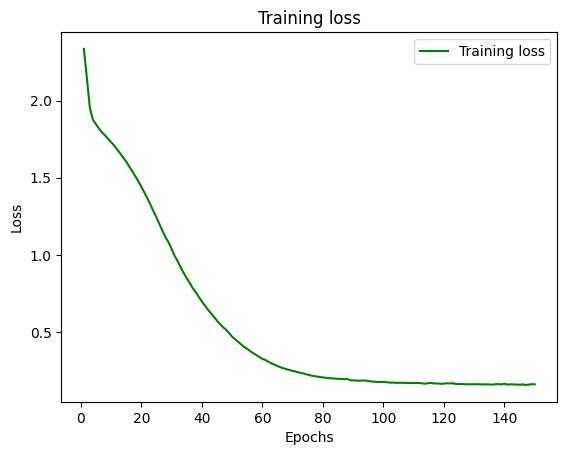

In [201]:
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

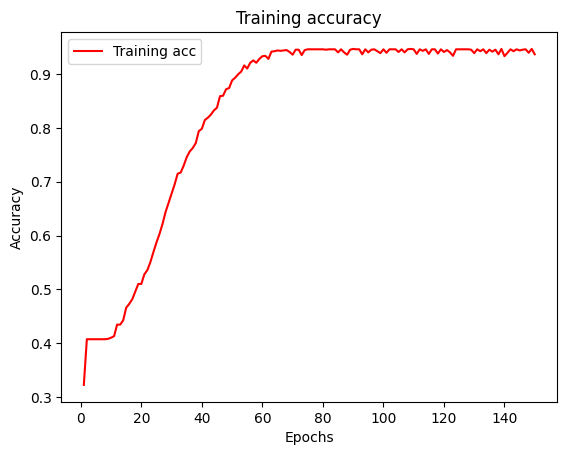

In [202]:
# Plot the training accuracy vs the number of epochs

acc_values = history_dict['accuracy'] 

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [203]:
model_1.evaluate(bow_mat_te, y_te_cat)

19/19 [==============================] - 0s 2ms/step - loss: 6.1900 - accuracy: 0.2750


[6.189960479736328, 0.2750000059604645]